In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


In [ ]:
!mkdir ~/.kaggle
!echo '{"username":"karthiksimhadri","key":"YOUR_KAGGLE_KEY"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d zalando-research/fashionmnist

!unzip fashionmnist.zip -d fashionmnist

mkdir: cannot create directory ‘/root/.kaggle’: File exists
Dataset URL: https://www.kaggle.com/datasets/zalando-research/fashionmnist
License(s): other
  0% 0.00/68.8M [00:00<?, ?B/s]
100% 68.8M/68.8M [00:00<00:00, 1.30GB/s]
Archive:  fashionmnist.zip
  inflating: fashionmnist/fashion-mnist_test.csv  
  inflating: fashionmnist/fashion-mnist_train.csv  
  inflating: fashionmnist/t10k-images-idx3-ubyte  
  inflating: fashionmnist/t10k-labels-idx1-ubyte  
  inflating: fashionmnist/train-images-idx3-ubyte  
  inflating: fashionmnist/train-labels-idx1-ubyte  


In [ ]:
!unzip fashionmnist.zip -d fashionmnist

Archive:  fashionmnist.zip
replace fashionmnist/fashion-mnist_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: fashionmnist/fashion-mnist_test.csv  
replace fashionmnist/fashion-mnist_train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: fashionmnist/fashion-mnist_train.csv  
  inflating: fashionmnist/t10k-images-idx3-ubyte  
  inflating: fashionmnist/t10k-labels-idx1-ubyte  
  inflating: fashionmnist/train-images-idx3-ubyte  
  inflating: fashionmnist/train-labels-idx1-ubyte  


In [ ]:
def load_data(csv_path='fashionmnist/fashion-mnist_train.csv'):
    data = np.loadtxt(csv_path, delimiter=',', skiprows=1)
    X = data[:, 1:] / 255.0  # normalize
    y = data[:, 0].astype(int)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    return X_train, y_train, X_val, y_val, X_test, y_test


In [ ]:
class MLP:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.001):
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01
        self.b2 = np.zeros((1, output_size))
        self.learning_rate = learning_rate

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return (x > 0).astype(float)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def forward(self, X):
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = self.relu(self.Z1)
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = self.softmax(self.Z2)
        return self.A2

    def compute_loss(self, Y_pred, Y_true):
        m = Y_true.shape[0]
        log_likelihood = -np.log(Y_pred[range(m), Y_true] + 1e-9)
        return np.sum(log_likelihood) / m

    def backward(self, X, Y_true):
        m = X.shape[0]
        Y_one_hot = np.zeros((m, self.W2.shape[1]))
        Y_one_hot[np.arange(m), Y_true] = 1
        dZ2 = self.A2 - Y_one_hot
        dW2 = np.dot(self.A1.T, dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m
        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * self.relu_derivative(self.Z1)
        dW1 = np.dot(X.T, dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1


In [ ]:
def train_model(model, X_train, y_train, X_val, y_val, epochs=50):
    loss_history, val_acc_history = [], []
    for epoch in range(epochs):
        Y_pred = model.forward(X_train)
        loss = model.compute_loss(Y_pred, y_train)
        model.backward(X_train, y_train)
        val_preds = np.argmax(model.forward(X_val), axis=1)
        val_acc = accuracy_score(y_val, val_preds)
        loss_history.append(loss)
        val_acc_history.append(val_acc)
        print(f"Epoch {epoch+1:3d} | Loss: {loss:.4f} | Val Acc: {val_acc:.4f}")
    return loss_history, val_acc_history

def evaluate_model(model, X_test, y_test):
    preds = np.argmax(model.forward(X_test), axis=1)
    return accuracy_score(y_test, preds)

def plot_metrics(loss_history, val_acc_history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(val_acc_history, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(loss_history, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()
    plt.show()


Epoch   1 | Loss: 2.3049 | Val Acc: 0.1130
Epoch   2 | Loss: 2.3047 | Val Acc: 0.1143
Epoch   3 | Loss: 2.3046 | Val Acc: 0.1150
Epoch   4 | Loss: 2.3045 | Val Acc: 0.1177
Epoch   5 | Loss: 2.3043 | Val Acc: 0.1190
Epoch   6 | Loss: 2.3042 | Val Acc: 0.1203
Epoch   7 | Loss: 2.3040 | Val Acc: 0.1218
Epoch   8 | Loss: 2.3039 | Val Acc: 0.1235
Epoch   9 | Loss: 2.3038 | Val Acc: 0.1258
Epoch  10 | Loss: 2.3036 | Val Acc: 0.1268
Epoch  11 | Loss: 2.3035 | Val Acc: 0.1290
Epoch  12 | Loss: 2.3034 | Val Acc: 0.1303
Epoch  13 | Loss: 2.3032 | Val Acc: 0.1313
Epoch  14 | Loss: 2.3031 | Val Acc: 0.1320
Epoch  15 | Loss: 2.3029 | Val Acc: 0.1335
Epoch  16 | Loss: 2.3028 | Val Acc: 0.1350
Epoch  17 | Loss: 2.3027 | Val Acc: 0.1367
Epoch  18 | Loss: 2.3025 | Val Acc: 0.1380
Epoch  19 | Loss: 2.3024 | Val Acc: 0.1388
Epoch  20 | Loss: 2.3023 | Val Acc: 0.1398
Epoch  21 | Loss: 2.3021 | Val Acc: 0.1410
Epoch  22 | Loss: 2.3020 | Val Acc: 0.1433
Epoch  23 | Loss: 2.3019 | Val Acc: 0.1438
Epoch  24 |

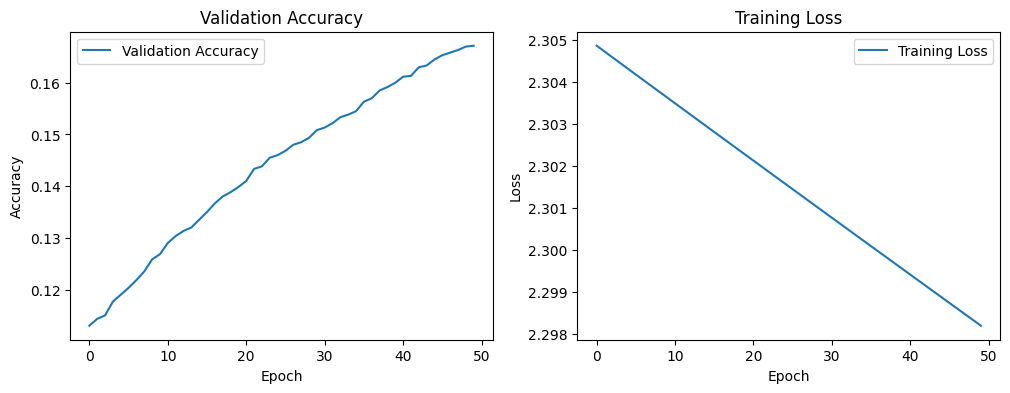

In [ ]:
# Main Execution
X_train, y_train, X_val, y_val, X_test, y_test = load_data()

model = MLP(input_size=784, hidden_size=512, output_size=10, learning_rate=0.001)

loss_history, val_acc_history = train_model(model, X_train, y_train, X_val, y_val, epochs=50)

test_acc = evaluate_model(model, X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

plot_metrics(loss_history, val_acc_history)


# CNN vs MLP on Fashion MNIST

This notebook compares a simple MLP model (using NumPy) and a CNN model (using Keras/TensorFlow) on the Fashion MNIST dataset.


In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

# Load and normalize Fashion MNIST data
(X_train_cnn, y_train_cnn), (X_test_cnn, y_test_cnn) = tf.keras.datasets.fashion_mnist.load_data()
X_train_cnn, X_test_cnn = X_train_cnn / 255.0, X_test_cnn / 255.0
X_train_cnn = X_train_cnn[..., np.newaxis]
X_test_cnn = X_test_cnn[..., np.newaxis]

# Split validation set
from sklearn.model_selection import train_test_split
X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(X_train_cnn, y_train_cnn, test_size=0.1, random_state=42)


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
# Build the CNN model
cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Train the CNN
cnn_history = cnn_model.fit(X_train_cnn, y_train_cnn, epochs=10,
                            validation_data=(X_val_cnn, y_val_cnn),
                            batch_size=64)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.6876 - loss: 0.8587 - val_accuracy: 0.8557 - val_loss: 0.3973
Epoch 2/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8382 - loss: 0.4435 - val_accuracy: 0.8765 - val_loss: 0.3308
Epoch 3/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8640 - loss: 0.3750 - val_accuracy: 0.8838 - val_loss: 0.3041
Epoch 4/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8812 - loss: 0.3292 - val_accuracy: 0.8945 - val_loss: 0.2793
Epoch 5/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8914 - loss: 0.2985 - val_accuracy: 0.8950 - val_loss: 0.2757
Epoch 6/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8972 - loss: 0.2818 - val_accuracy: 0.8987 - val_loss: 0.2679
Epoch 7/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9038 - loss: 0.2681 - val_accuracy: 0.9033 - val_loss: 0.2606
Epoch 8/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9122 - loss: 0.2451 - val_accuracy: 0

In [12]:
# Evaluate on test data
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(X_test_cnn, y_test_cnn, verbose=2)
print(f"CNN Test Accuracy: {cnn_test_acc:.4f}")


313/313 - 2s - 7ms/step - accuracy: 0.9028 - loss: 0.2632
CNN Test Accuracy: 0.9028


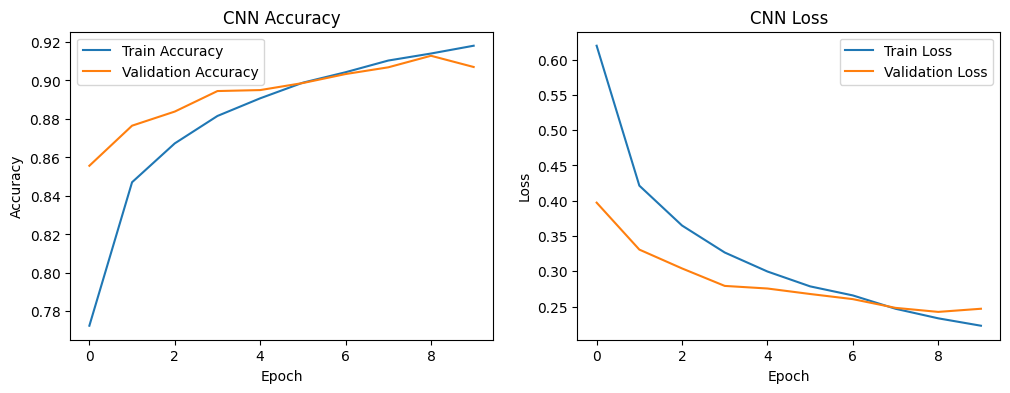

In [13]:
# Plot CNN training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title("CNN Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.title("CNN Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()
